In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
from sympy import Symbol, exp, sqrt, pi, Integral
from scipy.integrate import quad
from scipy.special import erf

import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda")

In [2]:
xx=[]
tx_snr = []
#H_f = 0.02515203629600967
#H_n = 0.40100521298869124
H_n=0.10025130324717278
H_f=0.04455613477652123
#H_f = 0.0402704167
#H_n = 0.367564136
#H_n = 0.3290121010789907
#H_f = 0.0395428085386695

snr = 60
for EbN0 in range(1,snr):
    #print([EbN0, H_f, H_n])
    xx.append([EbN0, H_f, H_n])
    tx_snr.append(math.pow(10,(EbN0/10)))
xx = torch.tensor(np.array(list(np.float_(xx)))).to(device)

In [3]:
m =nn.ReLU()
hidden = 8
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(3,hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden,hidden)
#         self.fc4 = nn.Linear(hidden,hidden)
#         self.fc5 = nn.Linear(hidden,hidden)
#         self.fc6 = nn.Linear(hidden,hidden)
        self.fc7 = nn.Linear(hidden,1)
    def forward(self, x):
        x = x.float()
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
#         x = m(self.fc4(x))
#         x = m(self.fc5(x))
#         x = m(self.fc6(x))
        x = m(self.fc7(x))
        return x


In [4]:
model=mlp().to(device)

# loading_model = "./output/model_20210719.pth"
loading_model = "./output/model_20221121_3881.pth"
model = torch.load(loading_model)
loss_fn = nn.MSELoss()

In [5]:
model.eval()
with torch.no_grad():
    output = model(xx).squeeze() #Different dimension may cause wrong results of backpropagation(Something called broadcasting)
#print(output/100)

In [6]:
def theory_f(tx_snr, H_f, p_n):
    return 0.25*(math.erfc(0.5*H_f*np.sqrt(tx_snr))+math.erfc((1-p_n-0.5)*H_f*np.sqrt(tx_snr)))

def theory_n(tx_snr, H_n, p_n):
    return 0.5*math.erfc(p_n*H_n/2*np.sqrt(tx_snr))

def theory_n_ip(tx_snr, H_n, p_n):
    x= Symbol('x')
    f = 1/sqrt(pi)*exp(-x**2)
    result = Integral(f,(x,H_n*(2*(1-p_n)- p_n)/2*sqrt(tx_snr),math.inf)) + Integral(f, (x, H_n*(p_n-2)/2*sqrt(tx_snr), -1/2*sqrt(tx_snr)*H_n))
    result = result.doit().evalf()/2
    result = (1-theory_f(tx_snr, H_n, p_n))*theory_n(tx_snr, H_n, p_n) + (theory_f(tx_snr, H_n, p_n) - result)
    return result

In [7]:
def FTPC(tx_snr, H_f, H_n, a):
    N0 = 1/np.log10(tx_snr)
    p_f = 1/((H_f/N0+H_n/N0)**(-a))*(H_f/N0)**(-a)
    p_n = 1/((H_f/N0+H_n/N0)**(-a))*(H_n/N0)**(-a)
    p_n = p_n/(p_f+p_n)
    return p_n

In [8]:
def qfunc(x):
    return 0.5-0.5*erf(x/np.sqrt(2))
def C(x):
    return np.log2(1+x)
def V(x):
    return (1-1/((1+x)**2))*np.log2(np.exp(1))**2
def n(x):
    t = 128
    err= 1e-5
    qe=qfunc(err)
    return np.sqrt((4*C(x)*qe**2*t+V(x)) + np.sqrt(V(x)))/(2*C(x)*qe)**2
def FBL(tx_snr, H_f, H_n):
    p_n =[]
    for i in range(1, 500):
        p_n.append(i/1000)
    N0 = 1/np.log10(tx_snr)
    t = np.zeros(500)
    for i in range(1,500):
        j = i-1
        sinr_n = (p_n[j]*H_n**2)/N0
        sinr_f = ((1-p_n[j])*H_f**2)/(p_n[j]*H_f**2+N0)
        
        #print(sinr_n, sinr_f)
        t[j]=n(sinr_n) + n(sinr_f)
    return p_n[np.argmin(t[0:499])]

In [9]:
proposed_F_BER = []
proposed_N_BER = []
proposed_NI_BER = []
proposed_avg_BER = []
fixed_F_BER = []
fixed_N_BER = []
fixed_NI_BER = []
fixed_avg_BER = []
fixed_avg_BER_03= []

FTPC_avg_BER = []
FBL_avg_BER = []
for i in range(1,snr):
    #print([EbN0, H_f, H_n])
    EbN0 = i-1
    p_n = output[EbN0]/100
    #proposed_F_BER.append(theory_f(tx_snr[EbN0], H_f, p_n))
    #proposed_N_BER.append(theory_n(tx_snr[EbN0], H_n, p_n))
    #proposed_NI_BER.append(theory_n_ip(tx_snr[EbN0], H_n, p_n))
    proposed_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n = 0.2
    #fixed_F_BER.append(theory_f(tx_snr[EbN0], H_f, p_n))
    #fixed_N_BER.append(theory_n(tx_snr[EbN0], H_n, p_n))
    #fixed_NI_BER.append(theory_n_ip(tx_snr[EbN0], H_n, p_n))
    fixed_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n= 0.3
    fixed_avg_BER_03.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n = FTPC(tx_snr[EbN0], H_f, H_n, a=0.4)
    FTPC_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    
    p_n = FBL(tx_snr[EbN0], H_f, H_n)
    FBL_avg_BER.append((theory_n_ip(tx_snr[EbN0], H_n, p_n) + theory_f(tx_snr[EbN0], H_f, p_n))/2)
    

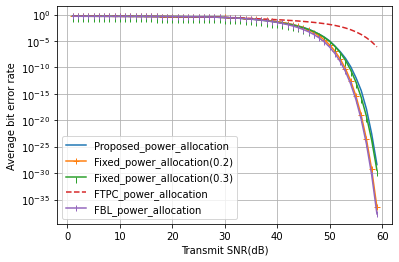

In [10]:
plt.figure()
#plt.plot(proposed_F_BER)
#plt.plot(proposed_N_BER)
#plt.plot(proposed_NI_BER)
EbN0 = range(1,snr)
plt.plot(EbN0, proposed_avg_BER)

#plt.plot(fixed_F_BER)
#plt.plot(fixed_N_BER)
#plt.plot(fixed_NI_BER)
plt.plot(EbN0, fixed_avg_BER,'-+')
plt.plot(EbN0, fixed_avg_BER_03, marker=3)

plt.plot(EbN0, FTPC_avg_BER, '--')

plt.plot(EbN0, FBL_avg_BER, '-|')

plt.legend(['Proposed_power_allocation','Fixed_power_allocation(0.2)','Fixed_power_allocation(0.3)','FTPC_power_allocation', 'FBL_power_allocation'])
#plt.legend(['Proposed_power_alloc(FU)' ,'Proposed_power_alloc(NU with perfect SIC)','Proposed_power_alloc(NU with imperfect SIC)','Proposed_power_alloc(average BER)', 'Fixed_power_alloc(FU)','Fixed_power_alloc(NU with perfect SIC)','Fixed_power_alloc(NU with imperfect SIC)','Fixed_power_alloc(average BER)'])
#plt.ylim((10^(-1), 10^(0)))

plt.xlabel('Transmit SNR(dB)') #(x 1000)')
plt.ylabel('Average bit error rate')
plt.semilogy()
plt.grid(True)
#plt.ylim(0,1000)
plt.show()
loss_temp = 0

In [11]:
for i in range(len(proposed_avg_BER)):
    print(proposed_avg_BER[i])

0.492950113377569
0.492090323364478
0.490475824417204
0.488550768851705
0.486474977075083
0.483966696198024
0.481189876968140
0.478458160073491
0.476348694155933
0.473776741377315
0.470683389104554
0.467224581353018
0.463354069655132
0.459120060528713
0.454479957297983
0.449361800338236
0.443826157906861
0.437863424362174
0.431393228631683
0.424491944843417
0.417057130901438
0.408947404557627
0.400030768907788
0.390167456475295
0.378682861002356
0.365074299220663
0.348953672950120
0.329985241468572
0.308114995792906
0.283739828022727
0.257517892681438
0.230060554811499
0.202209324028929
0.174764404573724
0.148552874373277
0.123503049952447
0.100218807030094
0.0795156374058402
0.0603351858319785
0.0438961411656704
0.0308210467298510
0.0204688173157193
0.0126578046393222
0.00715636347599881
0.00372922852988662
0.00167955195179072
0.000611537101109436
0.000196555117643405
5.28603599482012e-5
1.00883953654634e-5
1.11575765834018e-6
9.87444666318583e-8
5.50342739539778e-9
1.40726996101767e-

In [12]:
for i in range(len(proposed_avg_BER)):
    print(fixed_avg_BER[i])

0.491128731304991
0.490042038730586
0.488822677639247
0.487454853046197
0.485921105549902
0.484202235919469
0.482277272867797
0.480123506870595
0.477716619047299
0.475030939480308
0.472039871266945
0.468716510058488
0.465034465103281
0.460968832825981
0.456497167244712
0.451600107263724
0.446261035454107
0.440463755865364
0.434186757054822
0.427392382037854
0.420009607461733
0.411910859292296
0.402887133088674
0.392631692422848
0.380748654410334
0.366803207498521
0.350417473895957
0.331388341552335
0.309775997513949
0.285914199838439
0.260338841090130
0.233683796497160
0.206597040028000
0.179689009042086
0.153498572887600
0.128472691956088
0.104970281671849
0.0832946093113006
0.0637384548455290
0.0466095461496013
0.0322070731391123
0.0207451431511191
0.0122523694403434
0.00650183749216954
0.00302086776339191
0.00118826882511555
0.000378797704906412
9.25223132224890e-5
1.61306644167830e-5
1.83707749615774e-6
1.22348367794689e-7
4.14795917839442e-9
6.01352652768864e-11
2.99350864269611e-

In [13]:
for i in range(len(proposed_avg_BER)):
    print(fixed_avg_BER_03[i])

0.490225718245695
0.489026442034596
0.487680303457541
0.486169726919839
0.484475272274618
0.482575552406494
0.480447203474763
0.478064937188986
0.475401714076823
0.472429087144163
0.469117774661694
0.465438524862787
0.461363326190124
0.456866980638560
0.451928972766406
0.446535401460537
0.440680456646420
0.434366485288981
0.427601105775557
0.420389210662985
0.412717377303645
0.404528857175067
0.395689955344221
0.385954202041253
0.374938983663983
0.362136809506883
0.346982415177997
0.328978697747212
0.307849684994557
0.283658095074432
0.256830815857640
0.228086355753409
0.198315544935710
0.168479454699934
0.139548483966826
0.112454607578662
0.0880161630660945
0.0668333500952756
0.0491990037337405
0.0350761870773764
0.0241589490206203
0.0159860604463394
0.0100567676058714
0.00591201815882520
0.00316680241683656
0.00149550534457102
0.000598310653116037
0.000193494446079923
4.78202628488742e-5
8.42714302744363e-6
9.70945013530982e-7
6.55725887605478e-8
2.26210206526239e-9
3.35197610069588e

In [14]:
for i in range(len(proposed_avg_BER)):
    print(FTPC_avg_BER[i])

0.489154373736150
0.487822022455850
0.486325964977214
0.484646418405968
0.482761431391300
0.480646759639547
0.478275790718244
0.475619549827250
0.472646830388779
0.469324508326629
0.465618116135582
0.461492770185751
0.456914557351399
0.451852485563120
0.446281070571825
0.440183541206001
0.433555458870930
0.426408216419381
0.418771366458768
0.410692037852039
0.402228969866369
0.393438317655837
0.384349119944839
0.374929235762551
0.365048464169678
0.354453653704148
0.342776678479459
0.329592516582951
0.314525336098538
0.297371617584582
0.278193114810650
0.257347767237799
0.235459057838428
0.213336620022212
0.191849136926818
0.171754002852459
0.153524362493162
0.137246478332338
0.122646696678429
0.109249085036267
0.0965965439853803
0.0844271576544373
0.0727205267044256
0.0616179168235459
0.0512986331473137
0.0418903713469961
0.0334387651185912
0.0259289477119371
0.0193387853107152
0.0136878044338191
0.00904251552869901
0.00546778093538483
0.00295704815962369
0.00139058695047260
0.00054901

In [15]:
for i in range(len(proposed_avg_BER)):
    print(FBL_avg_BER[i])

0.490514018105889
0.489340518668508
0.488022166391540
0.486554320084204
0.484908007741800
0.483062525025090
0.480976981696393
0.478661203594100
0.476072780043932
0.473184197701704
0.469967135909576
0.466393278191717
0.462435430291072
0.458068940563973
0.453273323850531
0.448033812867390
0.442342265794896
0.436134105275581
0.429528236204258
0.422460584712053
0.414899753377500
0.406764569107338
0.397891365978787
0.388002074100670
0.376689100230903
0.363439075792782
0.347713302648509
0.329080391211003
0.307360455590261
0.282715623449235
0.255640265062444
0.226864602360259
0.197236391685596
0.167637981930926
0.138942639255128
0.111973541277259
0.0874402168351686
0.0658699840254332
0.0475739246883947
0.0326630509805722
0.0210842156730028
0.0126296312761983
0.00691884702114984
0.00340951414356506
0.00147966026925523
0.000548609010707371
0.000166276291546935
3.87780098344491e-5
6.44091849072125e-6
6.93007313280694e-7
4.30226945448601e-8
1.33555232589177e-9
1.73306241019928e-11
7.5038551817621

In [16]:
for i in range(len(tx_snr)):
    p_n = output[i]/100
    print(p_n)
    print('TX_SNR :', tx_snr[i])
    print('FU : ', theory_f(tx_snr[i], H_f, p_n))
    print('NU with PSIC : ', theory_n(tx_snr[i], H_n, p_n))
    print('NU with ISIC : ', theory_n_ip(tx_snr[i], H_n, p_n))

tensor(0., device='cuda:0')
TX_SNR : 1.2589254117941673
FU :  0.48590022689908285
NU with PSIC :  0.5
NU with ISIC :  0.499999999856054
tensor(0., device='cuda:0')
TX_SNR : 1.5848931924611136
FU :  0.48418064694552687
NU with PSIC :  0.5
NU with ISIC :  0.499999999783429
tensor(0.0563, device='cuda:0')
TX_SNR : 1.9952623149688795
FU :  0.48325010333606294
NU with PSIC :  0.49775139256910717
NU with ISIC :  0.497701545498344
tensor(0.1152, device='cuda:0')
TX_SNR : 2.51188643150958
FU :  0.48237977824592015
NU with PSIC :  0.494837831803827
NU with ISIC :  0.494721759457490
tensor(0.1618, device='cuda:0')
TX_SNR : 3.1622776601683795
FU :  0.4812736896590226
NU with PSIC :  0.4918615811586099
NU with ISIC :  0.491676264491144
tensor(0.2144, device='cuda:0')
TX_SNR : 3.9810717055349722
FU :  0.4803092481349799
NU with PSIC :  0.4879013232853886
NU with ISIC :  0.487624144261068
tensor(0.2594, device='cuda:0')
TX_SNR : 5.011872336272722
FU :  0.4791723854970704
NU with PSIC :  0.4835840603